Reference: https://www.youtube.com/playlist?list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P

In [ ]:
import lib._util.visualplot as vp

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import tqdm
import os

import IPython
from IPython.display import Audio

# Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.colors import DEFAULT_PLOTLY_COLORS

# LibROSA
import librosa

# Speech Features
from python_speech_features import mfcc, logfbank

# Scikit-Learn
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Constant Variable

In [ ]:
SOURCE_PATH_DATA = 'resources/data/instrument/'
OUT_PATH_GRAPH   = 'resources/output/instrument/graph/'

# Data Loading

In [ ]:
data_df = pd.read_csv(f'{SOURCE_PATH_DATA}instruments.csv', sep=',')

data_df.shape

In [ ]:
# Class distribution
data_df['label'].value_counts()

In [ ]:
# Take 1st sample from each class
sample_df = data_df.groupby('label').agg({
    'fname': 'first'
})

sample_df.shape

In [ ]:
for row in sample_df.itertuples():
    print(row.Index)
    IPython.display.display(Audio(f'{SOURCE_PATH_DATA}wav/{row.fname}'))

In [ ]:
# Filename uniqueness
data_df.groupby('fname').agg(count=('label', 'count'))['count'].describe()

In [ ]:
# Set filename as index
data_df.set_index('fname', inplace=True)

data_df.shape

In [ ]:
# Read audio file
for row in sample_df.itertuples():
    rate, signals = wavfile.read(f'{SOURCE_PATH_DATA}wav/{row.fname}')
    sample_df.at[row.Index, 'rate'] = rate
    sample_df.at[row.Index, 'signal_length'] = len(signals)
sample_df['audio_seconds'] = sample_df['signal_length'] / sample_df['rate']

sample_df

# Exploratory Data Analysis

In [ ]:
def envelope(signals, rate, threshold):
    window = int(rate / 10)
    mean_signals = pd.Series(signals).apply(np.abs).rolling(window=window, min_periods=1, center=True).mean()
    
    return (mean_signals > threshold).values

def calc_fft(signals, rate):
    signal_length = len(signals)
    frequencies   = np.fft.rfftfreq(signal_length, d=1 / rate)
    magnitudes    = np.abs(np.fft.rfft(signals) / signal_length)
    
    return magnitudes, frequencies

def calc_bank(signals, rate):
    nfft = int(np.ceil(rate / 40))
    
    return logfbank(signals, rate, nfilt=26, nfft=nfft).T

def calc_mfcc(signals, rate):
    nfft = int(np.ceil(rate / 40))
    
    return mfcc(signals, rate, numcep=13, nfilt=26, nfft=nfft).T

In [ ]:
# Create columns to hold array
columns = ['amplitude', 'amplitude_clean', 'fft_magnitude', 'fft_frequency',
           'stft', 'filter_bank', 'mel_spectogram', 'mfcc_psf', 'mfcc_librosa']
for column in columns:
    sample_df[column] = sample_df.apply(lambda x: [], axis=1)
    
# Audio signals
for row in sample_df.itertuples():
    signals, rate = librosa.load(f'{SOURCE_PATH_DATA}wav/{row.fname}', sr=row.rate)
    
    # Signal
    sample_df.at[row.Index, 'amplitude'] = signals
    
    # Noise detection
    remain_indexes = envelope(signals, rate, threshold=.0005)
    signals        = signals[remain_indexes]
    sample_df.at[row.Index, 'amplitude_clean'] = signals
    
    # FFT
    magnitudes, frequencies = calc_fft(signals, rate)
    sample_df.at[row.Index, 'fft_magnitude'] = magnitudes
    sample_df.at[row.Index, 'fft_frequency'] = frequencies
    
    # STFT
    sample_df.at[row.Index, 'stft'] = np.abs(librosa.stft(signals))
    sample_df.at[row.Index, 'stft'] = librosa.power_to_db(
        sample_df.at[row.Index, 'stft'],
        ref=np.max
    )
    
    # Filter bank
    sample_df.at[row.Index, 'filter_bank'] = calc_bank(signals, rate)
    
    # Mel Spectogram
    # Reference: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
    sample_df.at[row.Index, 'mel_spectogram'] = librosa.feature.melspectrogram(
        y=signals,
        sr=rate,
        n_mels=26
    )
    sample_df.at[row.Index, 'mel_spectogram'] = librosa.power_to_db(
        sample_df.at[row.Index, 'mel_spectogram'],
        ref=np.max
    )
    
    # MFCC - python_speech_features
    sample_df.at[row.Index, 'mfcc_psf'] = calc_mfcc(signals, rate)
    
    # MFCC - Librosa
    sample_df.at[row.Index, 'mfcc_librosa'] = librosa.feature.mfcc(
        y=signals,
        sr=rate,
        n_mfcc=13,
        n_mels=26
    )
#     sample_df.at[row.Index, 'mfcc_librosa'] = librosa.power_to_db(
#         sample_df.at[row.Index, 'mfcc_librosa'],
#         ref=np.max
#     )

### Wave-Plot
- Time-domain representation of signal
- Shows the loudness (amplitude) of sound wave changing over time
- Zero amplitude represents silence
- Reference: https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520

In [ ]:
# Signal
vp.wave(
    sample_df.reset_index().set_index('label'),
    amplitude='amplitude',
    title='Audio Signal',
    max_col=5,
    out_path=OUT_PATH_GRAPH
)

In [ ]:
# Signal (Clean)
vp.wave(
    sample_df.reset_index().set_index('label'),
    amplitude='amplitude_clean',
    title='Audio Signal (Clean)',
    max_col=5,
    out_path=OUT_PATH_GRAPH
)

### Fourier Transform
- Frequency-domain representation of signal
- Audio signal is composed of multiple "single-frequency sound waves" which travel together
- Decompose continuous signal into its constituent frequencies
- Human speech will usually have strong frequencies ranging from 0 to 1kHz
- Reference: https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520
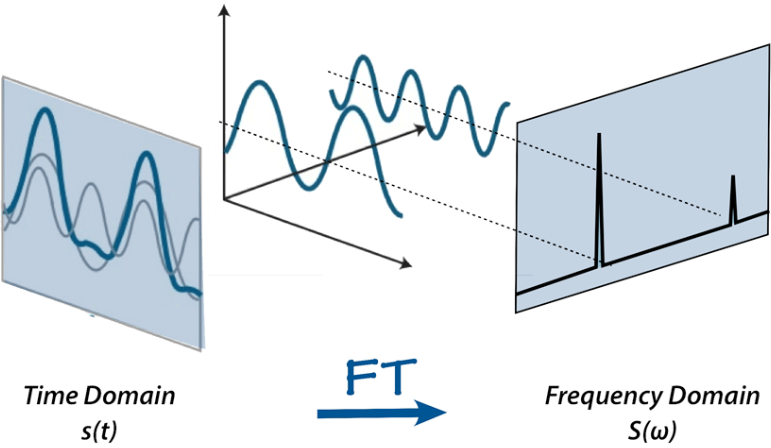

### Fast Fourier  Transform (FFT)
- Decompose discrete signal into its constituent frequencies

In [ ]:
# FFT
vp.fourier(
    sample_df.reset_index().set_index('label'),
    frequency='fft_frequency',
    magnitude='fft_magnitude',
    title='FFT',
    x_title='Frequency (kHz)',
    max_col=5,
    out_path=OUT_PATH_GRAPH
)

### Spectrogram
- Representation of frequencies of signal with time
- X axis represents time
- Y axis represents frequency
- Color represents magnitude (amplitude) of the observed frequency at a particular time

### Short-Time Fourier Transform

In [ ]:
# STFT
vp.spectogram(
    sample_df.reset_index().set_index('label'),
    z='stft',
    title='STFT',
    y_title='Frequency (Hz)',
    max_col=5,
    out_path=OUT_PATH_GRAPH
)

### Filter Bank
- Motivated by the nature of the speech signal and human perception of such signal

In [ ]:
# Filter Bank Coefficient
vp.spectogram(
    sample_df.reset_index().set_index('label'),
    z='filter_bank',
    title='Filter Bank',
    y_title='Frequency (Hz)',
    max_col=5,
    out_path=OUT_PATH_GRAPH
)

### Mel Spectogram

In [ ]:
# Mel Spectogram
vp.spectogram(
    sample_df.reset_index().set_index('label'),
    z='mel_spectogram',
    title='Mel Spectogram',
    y_title='Frequency (Hz)',
    max_col=5,
    out_path=OUT_PATH_GRAPH
)

### Mel-Frequency Cepstral Coefficients (MFCC)
- Motivated by the limitation of machine learning algorithms
- Decorrelate filter bank coefficients by applying Discrete Cosine Transform (DCT)
- Mel-spaced filterbank is a set of 20-40 (26 is standard) triangular filters
- Reference: http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
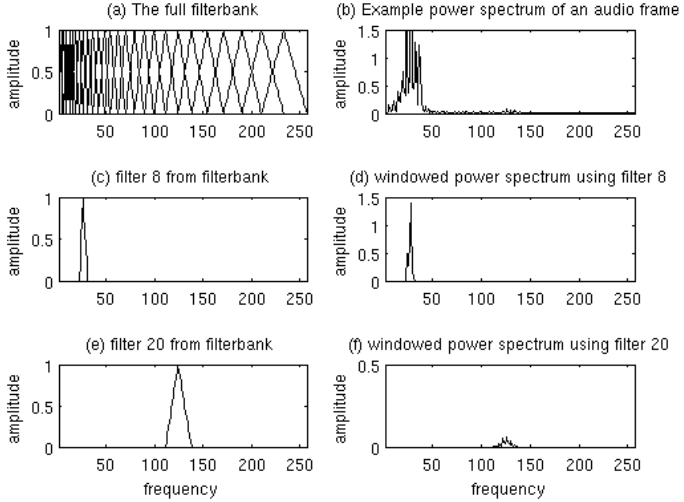

In [ ]:
# MFCC - PSF
vp.spectogram(
    sample_df.reset_index().set_index('label'),
    z='mfcc_psf',
    title='MFCC - PSF',
    y_title='MFCC',
    max_col=5,
    out_path=OUT_PATH_GRAPH
)

In [ ]:
# MFCC - Librosa
vp.spectogram(
    sample_df.reset_index().set_index('label'),
    z='mfcc_librosa',
    title='MFCC - Librosa',
    y_title='MFCC',
    max_col=5,
    out_path=OUT_PATH_GRAPH
)

# Classification

In [ ]:
data_df = pd.read_csv(f'{SOURCE_PATH_DATA}instruments.csv', sep=',')
data_df.set_index('fname', inplace=True)

data_df.shape

In [ ]:
for row in data_df.itertuples():
    rate, signals = wavfile.read(f'{SOURCE_PATH_DATA}wav/{row.Index}')
    data_df.at[row.Index, 'rate'] = rate
    data_df.at[row.Index, 'signal_length'] = len(signals)
data_df['audio_seconds'] = data_df['signal_length'] / data_df['rate']

In [ ]:
# Audio length summary
data_df.groupby('label')['audio_seconds'].describe()

In [ ]:
def encode(y, encoder=None):
    if encoder is None:
        encoder = LabelEncoder()
        encoder.fit(y)
        
    encode_y = encoder.transform(y)
    tmp_df = pd.DataFrame({
        'original': y,
        'encode': encode_y
    })
    encode_y = to_categorical(encode_y)
    
    tmp_df = tmp_df.groupby('original').agg(
        encode=('encode', 'first')
    )
    print(tmp_df)
    
    return encode_y, encoder

def inverse_encode(y, encoder):
    y = np.argmax(y, axis=1)
    y = encoder.inverse_transform(y)
    
    return y

In [ ]:
def compile_features_target(sample_per_file=1, encoder=None):
    config_dict = {
        'rate':     16000, # Downsampling the rate from 44.1 Hz to 16Hz
        'nfft':     512,
        'nfilter':  26,
        'nfeature': 13,
    }
    # Get 10% timeframes from signal
    config_dict['step'] = int(config_dict['rate'] / 10)

    X, y       = [], []
    _min, _max = np.inf, -np.inf

    for row in tqdm.tqdm(data_df.itertuples()):
        # Read audio signal
        _, signals  = wavfile.read(f'{SOURCE_PATH_DATA}wav/{row.Index}')
        
        # Noise detection
        remain_indexes = envelope(signals, rate, threshold=.0005)
        signals        = signals[remain_indexes]
        
        # Collect N samples from each audio signal
        for _ in range(sample_per_file):
            # Randomly select N timeframes from signal
            start_index    = np.random.randint(0, len(signals) - config_dict['step'])
            sample_signals = signals[start_index : start_index + config_dict['step']]

            # Calculate MFCC
            X_mfcc = mfcc(sample_signals, config_dict['rate'],
                          numcep=config_dict['nfeature'],
                          nfilt=config_dict['nfilter'],
                          nfft=config_dict['nfft']).T

            # Gather global min. & max. MFCC value
            _min = min(np.amin(X_mfcc), _min)
            _max = max(np.amax(X_mfcc), _max)

            X.append(X_mfcc)
            y.append(row.label)
    X, y = np.array(X), np.array(y)
    print(X.shape)

    # Feature normalization
    X = (X - _min) / (_max - _min)
    X = X.reshape(-1, X.shape[1], X.shape[2], 1)
    
    # Categorical encoding on target
    y, encoder = encode(y, encoder=encoder)
    
    return X, y, encoder

In [ ]:
# Compile features-target mapping
X_train, y_train, encoder = compile_features_target(sample_per_file=100)
X_val, y_val, _           = compile_features_target(sample_per_file=10, encoder=encoder)
X_test, y_test, _         = compile_features_target(sample_per_file=1, encoder=encoder)

print()
print('Train:      ', X_train.shape, y_train.shape)
print('Validation: ', X_val.shape, y_val.shape)
print('Test:       ', X_test.shape, y_test.shape)

In [ ]:
def compile_model(X):
    input_shape = (X.shape[1], X.shape[2], X.shape[3])
    
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1),
                     padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1),
                     padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1),
                     padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1),
                     padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    # Referecence: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    metrics = [
        'acc',
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall'),
    ]
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=.001, epsilon=.00001),
                  metrics=metrics)
    
    return model

In [ ]:
# Reference: https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
lrate = ReduceLROnPlateau(monitor='val_auc', factor=0.95, patience=15)

# Reference: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
es = EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=30, restore_best_weights=True)

model   = compile_model(X_train)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    callbacks=[lrate, es],
                    batch_size=32)

In [ ]:
def eval_classif(X, y, model):
    y_pred = model.predict(X)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)
    
    cofmat_df = pd.DataFrame(confusion_matrix(y_true, y_pred))
    cofmat_df.index.name   = 'True'
    cofmat_df.columns.name = 'Pred'

    print(cofmat_df)
    print()
    print(classification_report(y_true, y_pred, digits=5))

In [ ]:
# Test set evaluation
eval_classif(X_test, y_test, model)

In [ ]:
# Train set evaluation
eval_classif(X_train, y_train, model)

In [ ]:
# Validation set evaluation
eval_classif(X_val, y_val, model)

In [ ]:
# Learning Rate
data = []
data.append(go.Scatter(
    y=history.history['lr'],
    mode='lines',
    name='loss',
    marker={'color': DEFAULT_PLOTLY_COLORS[-1]},
))
fig1 = go.Figure(data=data)

# Loss
data = []
data.append(go.Scatter(
    y=history.history['loss'],
    mode='lines',
    name='loss',
    marker={'color': DEFAULT_PLOTLY_COLORS[0]},
))
data.append(go.Scatter(
    y=history.history['val_loss'],
    mode='lines',
    name='val_loss',
    marker={'color': DEFAULT_PLOTLY_COLORS[1]},
))
fig2 = go.Figure(data=data)

# Accuracy
data = []
data.append(go.Scattergl(
    y=history.history['acc'],
    mode='lines',
    name='accuracy',
    marker={'color': DEFAULT_PLOTLY_COLORS[0]},
))
data.append(go.Scattergl(
    y=history.history['val_acc'],
    mode='lines',
    name='val_accuracy',
    marker={'color': DEFAULT_PLOTLY_COLORS[1]},
))
fig3 = go.Figure(data=data)

# AUC
data = []
data.append(go.Scattergl(
    y=history.history['auc'],
    mode='lines',
    name='auc',
    marker={'color': DEFAULT_PLOTLY_COLORS[0]},
))
data.append(go.Scattergl(
    y=history.history['val_auc'],
    mode='lines',
    name='val_auc',
    marker={'color': DEFAULT_PLOTLY_COLORS[1]},
))
fig4 = go.Figure(data=data)

# Precision
data = []
data.append(go.Scatter(
    y=history.history['precision'],
    mode='lines',
    name='precision',
    marker={'color': DEFAULT_PLOTLY_COLORS[0]},
))
data.append(go.Scatter(
    y=history.history['val_precision'],
    mode='lines',
    name='val_precision',
    marker={'color': DEFAULT_PLOTLY_COLORS[1]},
))
fig5 = go.Figure(data=data)

# Recall
data = []
data.append(go.Scatter(
    y=history.history['recall'],
    mode='lines',
    name='recall',
    marker={'color': DEFAULT_PLOTLY_COLORS[0]},
))
data.append(go.Scatter(
    y=history.history['val_recall'],
    mode='lines',
    name='val_recall',
    marker={'color': DEFAULT_PLOTLY_COLORS[1]},
))
fig6 = go.Figure(data=data)

data_groups = [fig1['data'], fig2['data'], fig3['data'], fig4['data'], fig5['data'], fig6['data']]
vp.datagroups_subplots(data_groups,
                       max_col=3,
                       title='Metrics',
                       out_path=OUT_PATH_GRAPH,
                       subplot_titles=['Learning Rate', 'Loss', 'Accuracy', 'AUC', 'Precision', 'Recall'])